# Eager execution

In [64]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

In [3]:
i = tf.constant(0)
while i < 1000:
    i = tf.add(i, 1)
    
print(i)

tf.Tensor(1000, shape=(), dtype=int32)


In [9]:
# Boilerplate
# x = tf.placeholder(tf.float32, shape=[1, 1])
# m = tf.matmul(x, x)
# print(m)

# with tf.Session() as sess:
#     m_out = sess.run(m, feed_dict={x: [[2.]]})
# print(m_out)

x = [[2.]]
m = tf.matmul(x, x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


In [12]:
# Lazy loading
# x = tf.random_uniform([2, 2])
# with tf.Session() as sess:
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             print(sess.run(x[i,j]))

x = tf.random_uniform([2, 2])
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(x[i,j])

tf.Tensor(0.85267067, shape=(), dtype=float32)
tf.Tensor(0.17922592, shape=(), dtype=float32)
tf.Tensor(0.4420761, shape=(), dtype=float32)
tf.Tensor(0.60822797, shape=(), dtype=float32)


In [17]:
# Tensors Act Like NumPy Arrays

x = tf.constant([1.0, 2.0, 3.0])
print(x.numpy())
assert type(x.numpy()) == np.ndarray
squared = np.square(x)
for i in x:
    print(i)

[1. 2. 3.]
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)


# Gradient

In [21]:
def square(x):
    return x ** 2
grad = tfe.gradients_function(square)
print(square(3.))
print(grad(3.))

9.0
[<tf.Tensor: id=5158, shape=(), dtype=float32, numpy=6.0>]


In [27]:
x = tfe.Variable(2.0)
def loss(y):
    return (y - x ** 2) ** 2
grad_x = tfe.implicit_gradients(loss)
print(loss(7.0))
print(grad_x(7.0))
grad_y = tfe.gradients_function(loss)
print(grad_y(7.0))

tf.Tensor(9.0, shape=(), dtype=float32)
[(<tf.Tensor: id=5381, shape=(), dtype=float32, numpy=-24.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>)]
[<tf.Tensor: id=5417, shape=(), dtype=float32, numpy=6.0>]


In [29]:
print(tfe.value_and_gradients_function(loss)(7.0))
print(tfe.implicit_value_and_gradients(loss)(7.0))

(<tf.Tensor: id=5524, shape=(), dtype=float32, numpy=9.0>, [<tf.Tensor: id=5536, shape=(), dtype=float32, numpy=6.0>])
(<tf.Tensor: id=5583, shape=(), dtype=float32, numpy=9.0>, [(<tf.Tensor: id=5620, shape=(), dtype=float32, numpy=-24.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>)])


In [32]:
with tf.GradientTape() as tape:
    s = loss(7.0)
[grad_x] = tape.gradient(s, [x])
print(grad_x)

tf.Tensor(-24.0, shape=(), dtype=float32)


In [33]:
w1 = tfe.Variable(2.0)
w2 = tfe.Variable(3.0)
def weighted_sum(x1, x2):
    return w1 * x1 + w2 * x2

s = weighted_sum(5., 7.)
print(s.numpy()) # 31

31.0


In [36]:
with tf.GradientTape() as tape:
    s = weighted_sum(5., 7.)
    
[w1_grad, w2_grad] = tape.gradient(s, [w1, w2])
print(w1_grad.numpy(), w2_grad.numpy()) # 5.0 = gradient of s with regards to w1 = x1

5.0 7.0


In [39]:
grad_fn = tfe.gradients_function(weighted_sum)
x1_grad, x2_grad = grad_fn(5., 7.)
print(x1_grad.numpy(), x2_grad.numpy()) # 2.0 = gradient of s with regards to x1 = w1

2.0 3.0


In [41]:
def weighted_sum_with_weights(w1, x1, w2, x2):
    return w1 * x1 + w2 * x2

grad_fn = tfe.gradients_function(weighted_sum_with_weights, params=["w1", "w2"])
[w1_grad, w2_grad] = grad_fn(w1, 5., w2, 7.)
print(w1_grad.numpy(), w2_grad.numpy()) # 7.0 = gradient of s with regards to w2 = x2

5.0 7.0


In [43]:
grad_fn = tfe.implicit_gradients(weighted_sum)
[(w1_grad, w1_var), (w2_grad, w2_var)] = grad_fn(5., 7.)
print(w1_grad.numpy(), w2_grad.numpy()) # 5.0 = gradient of s with regards to w1 = x1

assert w1_var is w1
assert w2_var is w2

5.0 7.0


In [44]:
grad_fn = tfe.implicit_value_and_gradients(weighted_sum)
s, [(w1_grad, w1_var), (w2_grad, w2_var)] = grad_fn(5., 7.)
print(s.numpy()) # 31.0 = s = w1 * x1 + w2 * x2

31.0


# Huber Regression with Eager Execution

In [52]:
def read_birth_life_data(filename):
    """
    Read in birth_life_2010.txt and return:
    data in the form of NumPy array
    n_samples: number of samples
    """
    text = open(filename, 'r').readlines()[1:]
    data = [line[:-1].split('\t') for line in text]
    births = [float(line[1]) for line in data]
    lifes = [float(line[2]) for line in data]
    data = list(zip(births, lifes))
    n_samples = len(data)
    data = np.asarray(data, dtype=np.float32)
    return data, n_samples

In [47]:
DATA_FILE = 'data/birth_life_2010.txt'
data, n_samples = read_birth_life_data(DATA_FILE)
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

In [76]:
w = tfe.Variable(0.0)
b = tfe.Variable(0.0)

def predict(x):
    return w * x + b

def square_loss(y, y_pred):
    return (y - y_pred) ** 2

def huber_loss(y, y_pred, m=1.0):
    t = tf.abs(y - y_pred)
    return t ** 2 if t <= m else m * (2 * t - m)

def train(loss_fn):
    print("Trainning, loss function: " + loss_fn.__name__)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    
    
    def loss_for_example(x, y):
        return loss_fn(y, predict(x))
    
    grad_fn = tfe.implicit_value_and_gradients(loss_for_example)
    
    start = time.time()
    for epoch in range(100):
        total_loss = 0.0
        for x_i, y_i in tfe.Iterator(dataset):
            loss_, gradients = grad_fn(x_i, y_i)
            optimizer.apply_gradients(gradients)
            total_loss += loss_
            
        if epoch % 10 == 0:
            print("Epoch {0}: {1}".format(epoch, total_loss / n_samples))
    print("Took: %f seconds" % (time.time() - start))

In [77]:
train(huber_loss)

Trainning, loss function: huber_loss
Epoch 0: 106.16918182373047
Epoch 10: 53.64773178100586
Epoch 20: 42.586669921875
Epoch 30: 31.845298767089844
Epoch 40: 21.576385498046875
Epoch 50: 12.379732131958008
Epoch 60: 8.386137962341309
Epoch 70: 7.563107013702393
Epoch 80: 7.398852348327637
Epoch 90: 7.382768630981445
Took: 14.874278 seconds


In [78]:
w.numpy(), b.numpy()

(-6.270736, 85.626625)

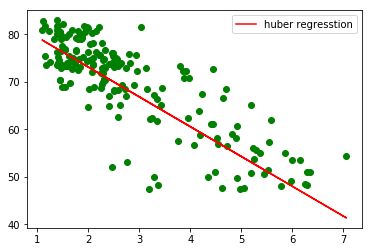

In [79]:
plt.plot(data[:,0], data[:,1], "go")
plt.plot(data[:,0], data[:,0] * w.numpy() + b.numpy(), "r",
         label="huber regresstion")
plt.legend()
plt.show()